# Statistically Testing Spike Responses to Stimulus

There are many ways to identify and select "responsive" cells for inclusion in analysis. In this notebook, we demonstrate one inclusion criterion from [{cite}`Siegle2021`](https://www.nature.com/articles/s41586-020-03171-x) which performs convolution.

Given the high-resolution capabilities of Neuropixel probes, they can record from hundreds to thousands of neurons simultaneously, resulting in a large and complex dataset. The spikes are recorded at precise time points, but for many types of analysis, it is helpful to convert these discrete spike events into a continuous measure of spiking activity. The convolution operation in this notebook does this, creating a "smoothed" version of the original spiking activity to improve the selection of responsive cells.


### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import convolve1d
from scipy.signal import exponential

%matplotlib inline

### Downloading Ecephys File
Change the values below to download the file you’re interested in. In this example, we the `Units` table of an Ecephys file from The Allen Institute's **Visual Coding - Neuropixels** dataset, so you'll have to choose one with the same kind of data. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, set `dandi_api_key` to your DANDI API key.

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-703279277/sub-703279277_ses-719161530.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Getting Units Data and Stimulus Data
Below, the `Units` table is retrived from the file. It contains many metrics for every putative neuronal unit, printed below. For the analysis in this notebook, we are only interested in the `spike_times` attribute. This is an array of timestamps that a spike is measured for each unit.

In [5]:
units = nwb.units
units.colnames

('waveform_duration',
 'cluster_id',
 'peak_channel_id',
 'cumulative_drift',
 'amplitude_cutoff',
 'snr',
 'recovery_slope',
 'isolation_distance',
 'nn_miss_rate',
 'silhouette_score',
 'velocity_above',
 'quality',
 'PT_ratio',
 'l_ratio',
 'velocity_below',
 'max_drift',
 'isi_violations',
 'firing_rate',
 'amplitude',
 'local_index',
 'spread',
 'waveform_halfwidth',
 'd_prime',
 'presence_ratio',
 'repolarization_slope',
 'nn_hit_rate',
 'spike_times',
 'spike_amplitudes',
 'waveform_mean')

In [6]:
units[:10]

,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,local_index,spread,waveform_halfwidth,d_prime,presence_ratio,repolarization_slope,nn_hit_rate,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
950921187,0.604355,4,850249267,481.80,0.425574,2.209140,-0.118430,17.537571,0.009496,0.036369,...,4,50.0,0.357119,2.962274,0.99,0.381716,0.473829,"[1.0439430431793884, 1.543311060144649, 2.7287...","[0.0001908626967721937, 0.00016134635752077775...","[[0.0, 0.5961149999999966, 5.378099999999993, ..."
950921172,0.521943,3,850249267,681.53,0.390098,1.959983,-0.109729,14.677643,0.003857,0.103446,...,3,40.0,0.260972,2.067810,0.99,0.536663,0.445946,"[10.406435026164546, 17.127986534673788, 18.48...","[0.00014485615850768024, 0.0001722424107984555...","[[0.0, -1.341600000000002, -0.4586399999999933..."
950921152,0.467002,2,850249267,1070.71,0.500000,2.522905,-0.109867,15.783665,0.017776,0.027818,...,2,50.0,0.247236,2.220043,0.99,0.566559,0.284058,"[1.2775103414155262, 2.3915133536963493, 3.701...","[0.00014859435856024575, 0.0001531048673600236...","[[0.0, -0.6427199999999993, -2.836079999999998..."
950921135,0.467002,1,850249267,253.42,0.500000,2.803475,-0.150379,26.666930,0.023742,0.076530,...,1,40.0,0.233501,2.339206,0.99,0.669090,0.590737,"[9.473732504122962, 13.198542576065163, 18.302...","[0.00032386170367170055, 0.0004518112387675137...","[[0.0, -3.2800950000000078, -6.087510000000009..."
950921111,0.439531,0,850249267,141.82,0.018056,4.647943,-0.328727,66.901065,0.006595,NaN,...,0,30.0,0.219765,4.395994,0.99,1.261416,0.952667,"[1.1677100445138795, 1.1707767194728813, 1.349...","[0.00015644521007973124, 0.000214412247939483,...","[[0.0, -0.9291749999999945, -6.120270000000007..."
950927711,1.455946,482,850249273,2.46,0.000895,1.651500,-0.039932,39.400278,0.000033,NaN,...,464,100.0,0.274707,5.557479,0.37,0.467365,0.000000,"[2613.8652081509977, 2624.5193369599215, 2734....","[0.00012946663895843286, 0.0001203425053985725...","[[0.0, 6.3216435986159105, 10.324204152249129,..."
950921285,2.087772,11,850249273,318.53,0.036848,1.379817,NaN,27.472722,0.000903,0.291953,...,11,100.0,0.288442,2.751337,0.89,0.372116,0.258065,"[39.04904580954626, 39.457346913598556, 40.495...","[7.768399792002802e-05, 8.405736507197006e-05,...","[[0.0, 5.330324999999991, 2.4261899999999486, ..."
950921271,0.947739,10,850249273,1008.50,0.001727,1.420617,-0.008204,30.027595,0.000707,0.406673,...,10,100.0,0.288442,3.847234,0.96,0.498618,0.796491,"[16.751918851114475, 26.127977537450867, 28.65...","[0.00016516929470324686, 0.0001501058102103845...","[[0.0, -3.103230000000032, 5.680349999999983, ..."
950921260,0.453266,9,850249273,175.00,0.000081,4.969091,-0.184456,89.804006,0.000000,0.223876,...,9,60.0,0.192295,5.274090,0.99,1.140487,0.997333,"[0.9620761551434307, 2.092045877265143, 2.4040...","[0.0003836112198262231, 0.0004093908262843732,...","[[0.0, 1.9104149999999982, -7.270770000000016,..."


In [7]:
units_spike_times = units["spike_times"]
print(units_spike_times.shape)

(3232,)


### Selecting Stimulus Times
Different types of stimulus require different kinds of inclusion criteria. Since the available stimulus tables vary significantly depending which NWB file and which experimental session you're analyzing, you'll may have to adjust some values below for your analysis. First, select which stimulus table you want by changing the key used below in `nwb.intervals`. The list of stimulus table names is printed below to inform this choice. Additionally, you'll have to modify the function `stim_select` to select the stimulus times you want to use. In this example, the stimulus type is the presentation of [Gabor patches](https://en.wikipedia.org/wiki/Gabor_filter), and the stimulus times are chosen where a Gabor patch is shown at x and y coordinates 40, 40. 

In [8]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations']


In [9]:
stim_table = nwb.intervals["gabors_presentations"]
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'temporal_frequency', 'x_position', 'y_position', 'color', 'mask', 'opacity', 'phase', 'size', 'units', 'stimulus_index', 'orientation', 'spatial_frequency', 'contrast', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,temporal_frequency,x_position,y_position,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,,,,
0,89.896827,90.130356,gabors,0.0,4.0,10.0,-10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."
1,90.130356,90.380565,gabors,0.0,4.0,-30.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(2, 1, timestamps pynwb.base.TimeSeries at 0x..."
2,90.380565,90.630774,gabors,0.0,4.0,20.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(3, 1, timestamps pynwb.base.TimeSeries at 0x..."
3,90.630774,90.880983,gabors,0.0,4.0,30.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(4, 1, timestamps pynwb.base.TimeSeries at 0x..."
4,90.880983,91.131199,gabors,0.0,4.0,0.0,-40.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(5, 1, timestamps pynwb.base.TimeSeries at 0x..."
5,91.131199,91.381415,gabors,0.0,4.0,30.0,30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(6, 1, timestamps pynwb.base.TimeSeries at 0x..."
6,91.381415,91.631631,gabors,0.0,4.0,0.0,10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(7, 1, timestamps pynwb.base.TimeSeries at 0x..."
7,91.631631,91.881847,gabors,0.0,4.0,-40.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(8, 1, timestamps pynwb.base.TimeSeries at 0x..."
8,91.881847,92.132049,gabors,0.0,4.0,-30.0,-30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(9, 1, timestamps pynwb.base.TimeSeries at 0x..."


In [10]:
### select start times from table that fit certain critera here

stim_select = lambda row: True
stim_select = lambda row: float(row.x_position) == 40 and float(row.y_position) == 40
stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]
print(len(stim_times))

45


### Getting Unit Spike Response Counts
With stimulus times selected for each trial, we can generate a spike matrix to perform our analysis on. The spike matrix will have dimensions `Units`, `Time`, and `Trials`. You may set `time_resolution` to be the duration, in seconds, of each time bin in the matrix. Additionally, `window_start_time`, and `window_end_time` can be set to the time, in seconds, relative to the onset of the stimulus at time 0. Finally, the stimulus matrix will also be averaged across trials to get the average spike counts over time for each unit, called `mean_spike_counts`.

In [11]:
# bin size for counting spikes
time_resolution = 0.005

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = -0.25
window_end_time = 0.75

In [12]:
# time bins used
bin_edges = np.arange(window_start_time, window_end_time, time_resolution)

# useful throughout analysis
n_units = len(units_spike_times)
n_trials = len(stim_times)

# calculate baseline and stimulus interval indices for use later
stimulus_onset_idx = int(-bin_edges[0] / time_resolution)

In [13]:
# 3D spike matrix to be populated with spike counts
spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

# populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
for unit_idx in range(n_units):
    spike_times = units_spike_times[unit_idx]

    for stim_idx, stim_time in enumerate(stim_times):
        # get spike times that fall within the bin's time range relative to the stim time        
        first_bin_time = stim_time + bin_edges[0]
        last_bin_time = stim_time + bin_edges[-1]
        first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
        spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

        # convert spike times into relative time bin indices
        bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
        
        # mark that there is a spike at these bin times for this unit on this stim trial
        for bin_idx in bin_indices:
            spike_matrix[unit_idx, bin_idx, stim_idx] += 1

# get average spikes by unit over time
mean_spike_counts = np.mean(spike_matrix, axis=2)
# make it spikes per second rather than per bin time
mean_firing_rate = mean_spike_counts / time_resolution

mean_firing_rate.shape

(3232, 200)

### Plotting Function
Here we define a plotting function to show the spiking behavior throughout the time window with the stimulus time clearly shown. It is used below to show the `mean_spike_counts` as well as the relative change in spike counts at the onset of the stimulus. The plot below is not super useful for analysis yet; the spikes will be convolved and firing rates will be normalized for a clearer view below.

In [14]:
### method to show plot of spike counts of units over time

def show_counts(counts_array, title="", c_label="", aspect="auto", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(6,12)) # change fig size for different plot dimensions
    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect=aspect,
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    ax.plot([0, 0],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")

    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

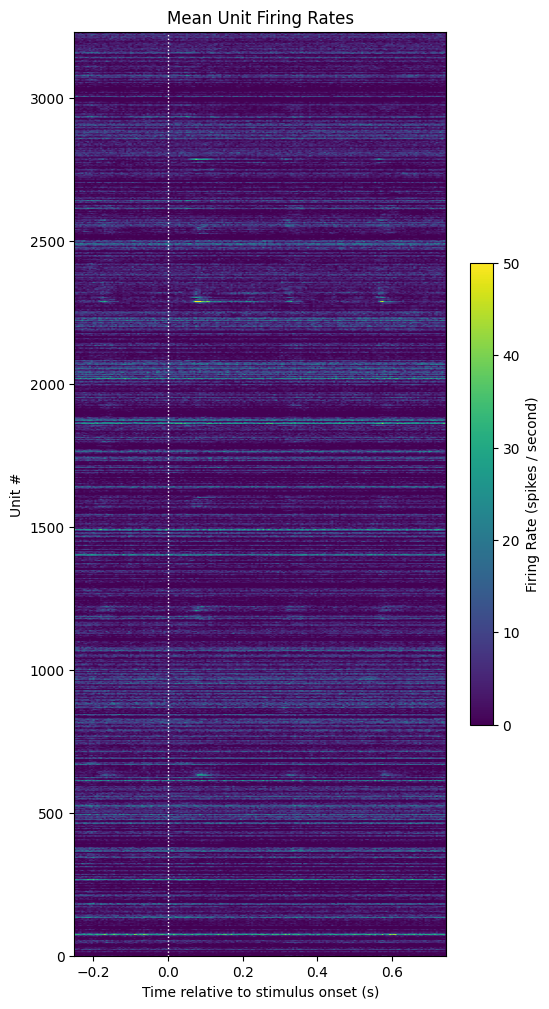

In [15]:
show_counts(mean_firing_rate,
            title="Mean Unit Firing Rates",
            c_label=f"Firing Rate (spikes / second)",
            vmin=0,
            vmax=50)

### Computing SDFs
The inclusion criteria discussed in [{cite}`Siegle2021`](https://www.nature.com/articles/s41586-020-03171-x) consists of a few steps. They convolve the spike counts for each trial with a causal exponential filter, convert from spike counts to firing rate, subtract the mean firing rate of the baseline window, and then average across trials. 

Then the mean firing rate across different trials is calculated. The end result is a matrix that provides a smoothed, continuous, and normalized representation of neuronal firing activity, which is often easier to work with and interpret than raw spike times, particularly when dealing with large populations of neurons. As can be seen below, the normalized firing rate plot identifies a small set of responsive neurons.

Below, the exponential filter used for the convolution is shown shown as well as the convolved SDFs for each unit with the baseline firing rates subtracted. To get a precise description of this calculation, see page 15 of Siegle et al. The code for the SDF calculation can be found [here](https://github.com/corbennett/ephys_behavior/blob/master/analysis_utils.py)

Text(0.5, 1.0, 'Causal Exponential Filter')

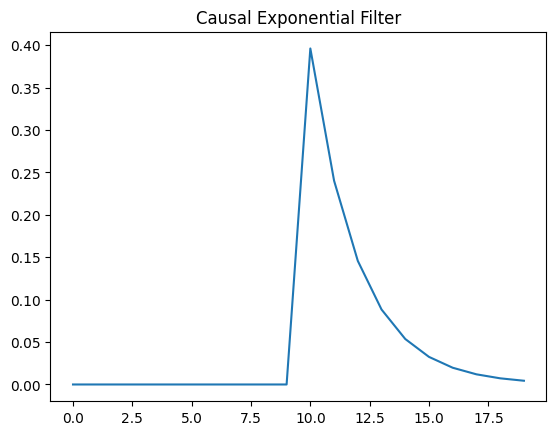

In [16]:
sigma = 0.01

filtPts = int(5*sigma / time_resolution)
expFilt = np.zeros(filtPts*2)
expFilt[-filtPts:] = exponential(filtPts, center=0, tau=sigma/time_resolution, sym=False)
expFilt /= expFilt.sum()

plt.plot(expFilt)
plt.title("Causal Exponential Filter")

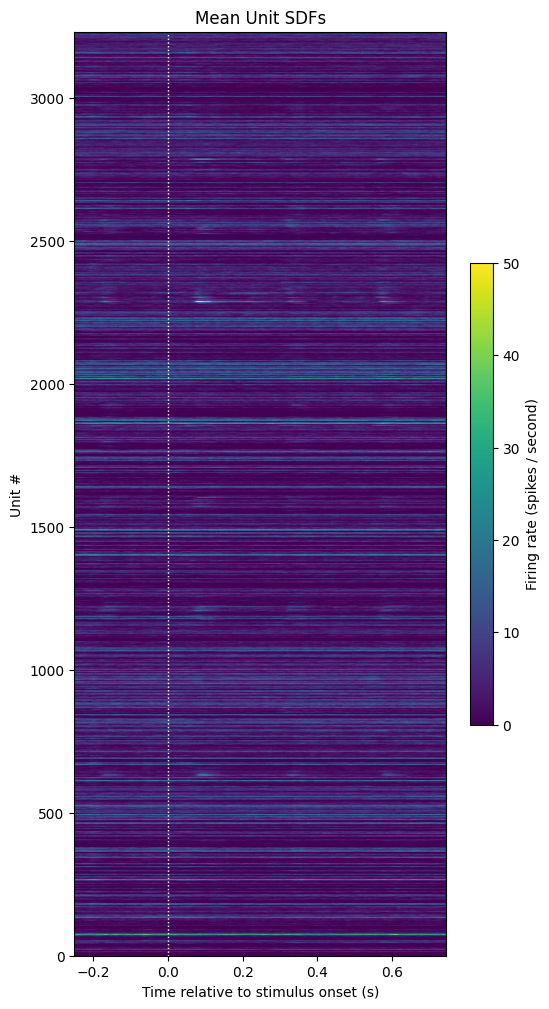

In [17]:
# convolve spike matrix with the causal exponential filter
sdfs = convolve1d(spike_matrix, expFilt, axis=1)

# convert from spike counts to firing rate
sdfs /= time_resolution

show_counts(np.mean(sdfs, axis=2),
            title="Mean Unit SDFs",
            c_label="Firing rate (spikes / second)",
            vmin=0,
            vmax=50)

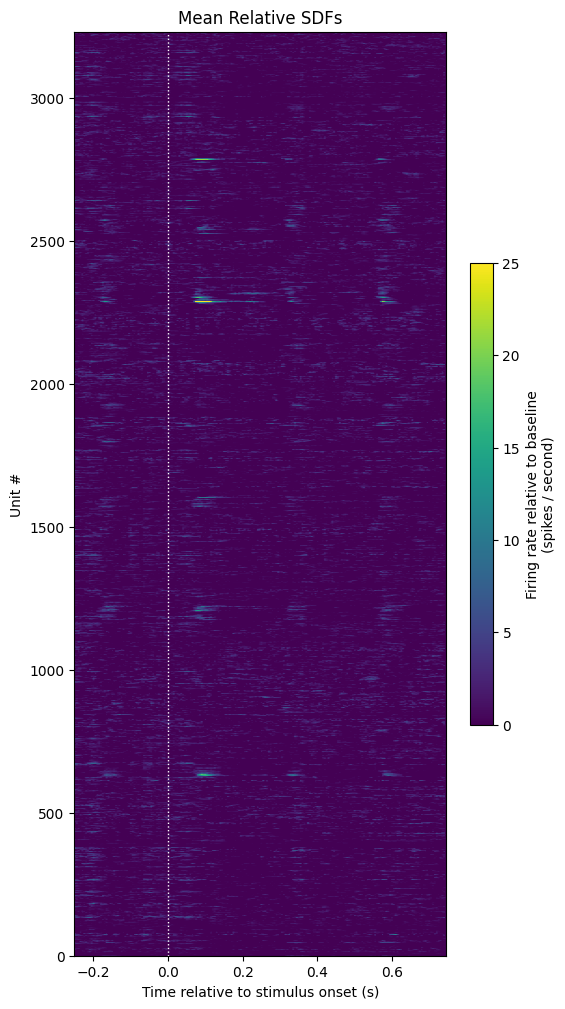

In [18]:
# subtract baseline SDF from sdfs to yield change in firing rate
baseline_sdfs = np.mean(sdfs, axis=1)
normalized_sdfs = sdfs - np.expand_dims(baseline_sdfs, axis=1)

# compute the mean sdf across trials
mean_normalized_sdfs = np.mean(normalized_sdfs, axis=2)

show_counts(mean_normalized_sdfs,
            title="Mean Relative SDFs",
            c_label="Firing rate relative to baseline\n(spikes / second)",
            vmin=0,
            vmax=25)

### Selecting Units

Units are included in their analysis if;

*"their mean firing rate was greater than 0.1 spikes per second and the peak of the mean SDF after image change was greater than 5 times the standard deviation of the mean SDF during the baseline window"*

Therefore the final step is to select units from our array which fit these two criteria. The selected unit's normalized mean firing rates are shown below. It can be seen that a majority of units (2315) were included.

In [19]:
evoked_firing_rates = np.mean(mean_normalized_sdfs[:,stimulus_onset_idx:], axis=1)
active_units = evoked_firing_rates > 0.1

sdf_response_peaks = np.max(mean_normalized_sdfs[:,stimulus_onset_idx:], axis=1)
responsive_units = sdf_response_peaks > 5*np.mean(baseline_sdfs, axis=1)

selected_units = mean_normalized_sdfs[active_units & responsive_units]
selected_units.shape

(27, 200)

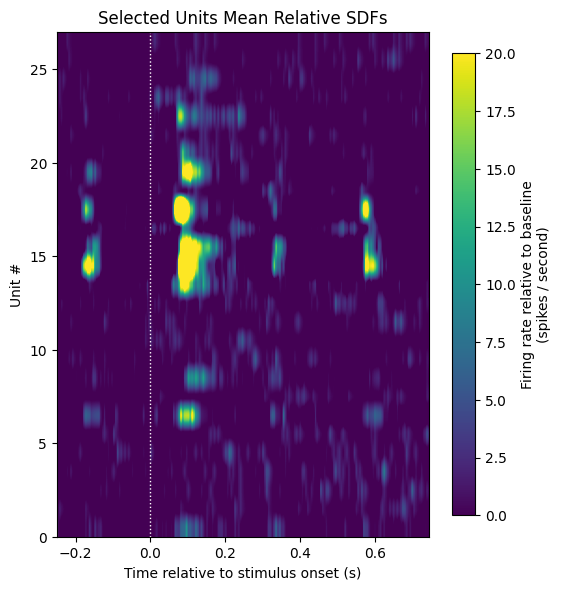

In [20]:
show_counts(selected_units,
            title="Selected Units Mean Relative SDFs",
            c_label="Firing rate relative to baseline\n(spikes / second)",
            aspect=0.05,
            vmin=0,
            vmax=20)